##### AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>


In [ ]:
#@title
%%html
<iframe src="https://www.polskacyfrowa.gov.pl/media/48246/FE_POPC_poziom_pl-1_rgb.jpg" width="800"></iframe>


# Uczenie głębokie

Jacek Rumiński, Politechnika Gdańska, Wydział ETI, Katedra Inżynierii Biomedycznej

**Wykład 7:** Przenoszenie (transfer) wiedzy

**Przykład (1):** Wykorzystanie modeli


W ramach tego notatnika przedstawiamy przykładowe kody umożliwiające praktyczne zapoznanie się z wykorzystaniem przetrenowanych modeli oraz trenowaniem modeli z zastosowaniem transferu wiedzy.



Wskażmy pakiety, z jakich będziemy korzystać:


In [ ]:
import numpy as np
import datetime, os
import matplotlib.pyplot as plt
import matplotlib

import tensorflow as tf
from tensorflow.keras.datasets import cifar10

AUTOTUNE = tf.data.experimental.AUTOTUNE

# You can try to change your Google Colab environment to GPU
print(tf.__version__)

# You can always check which packages are installed using:
# !pip list

2.7.0


In [ ]:
# Check if you have GPU resources (Runtime / Change runtime type -> GPU)
!nvidia-smi

Thu Nov 25 11:32:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Check devices using TF
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


W ramach wcześniej przedstawianych materiałów uczyliśmy się budowania modeli, ich trenowania oraz utrwalania w formie plików. Odtworzenie modelu z plików jest ważną własnością sztucznej inteligencji. Wytrenowany model może być bardzo szybko i łatwo przeniesiony do dowolnej liczby urządzeń w dowolnej lokalizacji na świecie (transfer plików, dostęp w chmurze). W odrożnieniu od bardzo długotrwałego procesu uczenia osób przenoszenie i zastosowanie wiedzy w formie modeli SI jest praktycznie błyskawiczne.

Zapoznajmy się z prostym przykładem wykorzystania gotowego (tj. ze zdefiniowaną architekturą, przetrenowanymi parametrami).

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  117k  100  117k    0     0   458k      0 --:--:-- --:--:-- --:--:--  458k


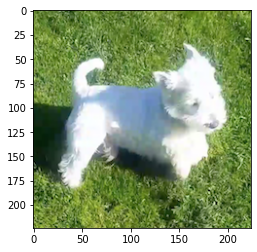

In [ ]:
!curl -o test.png "https://raw.githubusercontent.com/dartfather/ml/main/test11.png"
# !ls -la

img_path = 'test.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))

plt.imshow(img)
plt.show()

In [ ]:
model = tf.keras.applications.ResNet50(weights='imagenet')


x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.resnet50.preprocess_input(x)

preds = model.predict(x)
print("\n\nPredicted class:", tf.keras.applications.resnet50.decode_predictions(preds, top=3)[0])

49152/35363 [=========================================] - 0s 0us/step


Predicted class: [('n02098286', 'West_Highland_white_terrier', 0.98552483), ('n02095889', 'Sealyham_terrier', 0.0069828536), ('n02085936', 'Maltese_dog', 0.0047958368)]


Oczywiście możemy w analogiczny sposób wykorzystać inne dostępne modele w TF, jak również modele własne (czudze) utrwalone do plików. Uczyliśmy się wcześniej jak wczytywać utrwalone modele.

Rozpatrzmy teraz przykładowe metody tranferu wiedzy bazujące na modelu (sieci neuronowej). W tym zakresie rozważymy dwa scenariusze:
- wykorzystanie modelu bazowego wytrenowanego dla określonej dziedziny, dostarczającego zespół cech - architektura + wagi,
- wykorzystanie modelu bazowego wytrenowanego dla określonej dziedziny, dostarczającego zespół cech - tylko architektura.



Ponownie będziemy chcieli zastosowań nowy model dla danych CIFAR-10. Przykład wykorzystamy jedynie do demonstracji użycia modelu - nie jest on optymalizaowany ze względu na wynik jakości rozpatrywanego problemu klasyfikcji danych. Również kody źródłowe są tak skonstruowane, aby przedstawić kolejne kroki działań i nie są optymalizowane.

Zachęcem do eksperymentowania na innych bazach danych takich jak CIFAR-100, ImageNet, itp.

Zróbmy eksperyment ponownie z danymi CIFAR-10.

170508288/170498071 [==============================] - 3s 0us/step
True original label : 6 frog


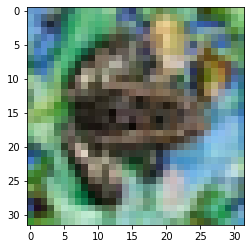

In [ ]:
# Load data and split to training and test datasets

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names = [
'airplane','automobile','bird', 'cat', 'deer' ,
'dog', 'frog', 'horse', 'ship', 'truck']

# Data properties
image_width = 32;
image_height = 32;
image_components = 3

# Show an example
example = 200
class_id = y_train[example].item()

plt.rcParams["axes.grid"] = False
plt.imshow(x_train[example])
print("True original label :", class_id, class_names[class_id])


Zdefiniujmy ważne parametry i utwórzmy źródła danych zgodnie z tf.data.Dataset

In [ ]:
no_of_classes = 10

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))



Zdefiniujmy funkcję wstępnego przetwarzania danych realizującą augmentację. wykorzystamy ją w potoku wstępnego przetwarznia danych przy przygotowaniu porcji danych (batchy).

In [ ]:
def preprocess_images(image, label):

    # apply simple augmentations
    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_hue(image, 0.2)

    return image, label

Zdefiniujmy źródło danych z potokiem przetwarzania.


Pamiętajmy również, że im większy rozmiar porcji danych (rozmiar danych i batch) tym więcej potrzebujemy pamięci.

<b>UWAGA! Ze względu na rozmiary danych wejściowych i budowę modeli bazowych trening może trwać bardzo długo. Dlatego koniecznie należy stosować tryb GPU w Google Colab, a w miarę możliwości pracować w innym środowisku z dostępną kartą graficzną. </b>

In [ ]:
# Preprocessing
buffer_size = 1024
batch_size = 64


train_ds = (train_ds
                  .map((lambda x, y: preprocess_images(x, y)), num_parallel_calls=AUTOTUNE)
                  .shuffle(buffer_size=buffer_size)
                  .batch(batch_size=batch_size, drop_remainder=True)
                  .prefetch(AUTOTUNE))

valid_ds = (valid_ds
                  .shuffle(buffer_size=buffer_size)
                  .batch(batch_size=batch_size, drop_remainder=True)
                  .prefetch(AUTOTUNE))

W demonstracji transferu wiedzy wykorzystamy modele, pierwotnie trenowane na bazie ImageNet z obrazami na wejściu o rozmiarach 224x224x3. Dlatego zdefiniujmy operację przeskalowania danych.

In [ ]:
img_height_dst = 224
img_width_dst = 224
img_depth_dst = 3

input_shape_dst = (img_height_dst, img_width_dst, img_depth_dst)

resize_layer = tf.keras.Sequential([
    tf.keras.layers.Resizing(input_shape_dst[0], input_shape_dst[1],interpolation='bicubic'),
    # It is better to use preprocess_input() function for the particular base_model in transfer learning
    tf.keras.layers.Rescaling(1./255),
])


Zdefiniujmy funkcję generacji modelu złożonego z modelu przeskalowania danych, modelu bazowego (transfer wiedzy) i nowej "głowy" modelu.

In [ ]:
def get_Model_Augm_TL(input_shape, no_of_classes=10, weights='imagenet', base_trainable=False):
    # Building Model
    prep_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        resize_layer,
        ])

    inputs = tf.keras.Input(shape=input_shape)

    x = prep_model(inputs)

    base_model = tf.keras.applications.ResNet50V2(
        include_top=False, weights=weights,
        input_shape=x.shape[1:],
    )

    # for layer in model.layers[:-6]:
    #     layer.trainable = False

    for layer in base_model.layers:
        layer.trainable=base_trainable

    x = base_model(x)

    # Add Top Layers (Head Layers)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x =  tf.keras.layers.Dense(1024)(x)
    outputs = tf.keras.layers.Dense(no_of_classes, activation='softmax' )(x)

    model = tf.keras.Model(inputs, outputs, name='res_tl_1')

    return model

Ponownie zdefiniujmy funkcję przydatną w treningu modelu.

In [ ]:
def train_model(model, callbacks, opt, epochs=10, batch_size=32):
  """
  Train model - use some global variable (you can modify the definition
                to make this function more univeral)

  """

  model.compile(
    # Choose the optimizer
    optimizer=opt,
    # we use sparse version of the loss -> we do not need to use to_categorical()
    loss='sparse_categorical_crossentropy',
    # Introduce additional metric
    metrics=['accuracy']
  )

  model.fit(train_ds,
            epochs=epochs,
            batch_size=batch_size,
            # Use test data to perform validation
            validation_data=valid_ds,
            # Assign reference to the TB callback function
            callbacks=callbacks)

Przeprowadźmy trening nowego modelu zakładając "zamrożenie" warstw modelu bazowego.

In [ ]:
input_shape = (image_height, image_width, image_components)

# Get instance of the model NOT CHANGING the previously trained CNN layers (of ResNet)
model_to_train = get_Model_Augm_TL(input_shape, no_of_classes, base_trainable=False)

model_to_train.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "res_tl_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 10)                1025

In [ ]:
# Use "logs" folder for TB data
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# All callback functions
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# Add LR scheduler that changes the learning rate WHEN val_loss is not changing
lr_scheduler =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                     patience=5, factor=0.5,
                                                     min_lr=1e-6, verbose=1)
callbacks = [lr_scheduler, tensorboard_callback]

# Please check other No. of epochs
epochs = 5
learning_rate = 0.01

# You can try different optimalization algorithms
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate*0.1, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Start training
train_model(model_to_train, callbacks=callbacks, opt=sgd, epochs=epochs,
            batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
781/781 [==============================] - 357s 449ms/step - loss: 0.5166 - accuracy: 0.8336 - val_loss: 0.4311 - val_accuracy: 0.8526 - lr: 0.0100
Epoch 2/5
781/781 [==============================] - 349s 447ms/step - loss: 0.3893 - accuracy: 0.8671 - val_loss: 0.4332 - val_accuracy: 0.8526 - lr: 0.0100
Epoch 3/5
781/781 [==============================] - 350s 448ms/step - loss: 0.3600 - accuracy: 0.8774 - val_loss: 0.4218 - val_accuracy: 0.8588 - lr: 0.0100
Epoch 4/5
781/781 [==============================] - 350s 448ms/step - loss: 0.3412 - accuracy: 0.8829 - val_loss: 0.4067 - val_accuracy: 0.8648 - lr: 0.0100
Epoch 5/5
781/781 [==============================] - 350s 448ms/step - loss: 0.3295 - accuracy: 0.8864 - val_loss: 0.4457 - val_accuracy: 0.8501 - lr: 0.0100


Przeprowadźmy następnie trening nowego modelu zakładając uczenie parametrów wszystkich warstw modelu (tj. łącznie z bazowym).

In [ ]:
input_shape = (image_height, image_width, image_components)

# Get instance of the model NOT CHANGING the previously trained CNN layers (of ResNet)
model_to_train = get_Model_Augm_TL(input_shape, no_of_classes, base_trainable=True)

model_to_train.summary()

Model: "res_tl_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 10)                10250     
                                                          

In [ ]:
# Use "logs" folder for TB data
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# All callback functions
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# Add LR scheduler that changes the learning rate WHEN val_loss is not changing
lr_scheduler =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                     patience=5, factor=0.5,
                                                     min_lr=1e-6, verbose=1)
callbacks = [lr_scheduler, tensorboard_callback]

# Redefine hiperparameters - e.g. use more epoch in the experiments
# epochs = 200
epochs = 20
learning_rate = 0.01

# You can try different optimalization algorithms
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate*0.1, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Start training
train_model(model_to_train, callbacks=callbacks, opt=sgd, epochs=epochs,
            batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
781/781 [==============================] - 964s 1s/step - loss: 0.3955 - accuracy: 0.8674 - val_loss: 0.3092 - val_accuracy: 0.8989 - lr: 0.0100
Epoch 2/20
781/781 [==============================] - 954s 1s/step - loss: 0.1666 - accuracy: 0.9441 - val_loss: 0.2533 - val_accuracy: 0.9192 - lr: 0.0100
Epoch 3/20
781/781 [==============================] - 954s 1s/step - loss: 0.1029 - accuracy: 0.9652 - val_loss: 0.2571 - val_accuracy: 0.9210 - lr: 0.0100
Epoch 4/20
781/781 [==============================] - 957s 1s/step - loss: 0.0772 - accuracy: 0.9732 - val_loss: 0.2837 - val_accuracy: 0.9153 - lr: 0.0100
Epoch 5/20
781/781 [==============================] - 954s 1s/step - loss: 0.0571 - accuracy: 0.9805 - val_loss: 0.2669 - val_accuracy: 0.9243 - lr: 0.0100
Epoch 6/20
781/781 [==============================] - 955s 1s/step - loss: 0.0426 - accuracy: 0.9851 - val_loss: 0.1991 - val_accuracy: 0.9452 - lr: 0.0100
Epoch 7/20
781/781 [==============================] - 956s 1s/st

Pamiętajmy, że mając instancję modelu możemy różnie zmieniać właściwości warstw.

Przykładowo, podany poniżej kod umożliwi nam kontrolowanie od której warstwy wprowadzamy trening parametrów:

```Python

for count, layer in enumerate(base_model.layers):
       
        if count > FREEZE_LAYER:
            layer.trainable = True
        else:
            layer.trainable = False
```

Możemy również zmienić pojedynczą warstwę, część warstw, itp.

```Python

base_model = tf.keras.applications.mobilenet.MobileNet()
# Get output from the penultimate layer
x = base_model.layers[-1].output

# And change the last layers, e.g. adding extra Dense layers:
x = tf.keras.layers.Dense(512)(x)
output = tf.keras.layers.Dense(10, activation = "softmax")(x)
model = Model(inputs = base_model.input, outputs = output)

```

Zachęcam do eksperymentowania. Warto np. pobrać bazę ImageNet (https://image-net.org/download.php) i spróbować przeprowadzić trening modelu (Uwaga! Zbiór danych jest obszerny i proces uczenia może trwać bardzo długo - w zależności od dostępnej infrastruktury obliczeniowej). Można również poeksperymentować z wersjami ImageNet o pomniejszonych rozmiarach obrazów.


<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>